# Erstellung eines ARIMA-Modells
## zur Vorhersage des Energieverbrauchs
1. [Beschränkung des Datensatzes](#1)
1. [ARIMA-Modellparameter manuell entwickeln](#2)
1. [AutoARIMA-Modell](#3)
1. [Zurück zum Standard ARIMA-Modell](#4)

In [1]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [3]:
def print_metrics(actual, predicted):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param actual: Array der tatsächlichen Werte.
    :param predicted: Array der vorhergesagten Werte.
    """
    actual, predicted = np.array(actual), np.array(predicted)

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MAPE: {round(mape, 2)} %")

In [4]:
df = pd.read_csv("../input/2024-01-12/austin10_hourly.csv")
df.timestamp = pd.to_datetime(df.timestamp)

<a id="1"></a>
## 1. Beschränkung des Datensatzes

In [5]:
# Funktion, um die Anzahl der Features und die Anzahl der gefüllten 'use'-Spalten zu zählen
def count_info(group):
    n_features = group.notnull().any().sum()
    n_use_data = group.use.notnull().sum()
    return pd.Series({'n_features': n_features, 'n_use_data': n_use_data})

# Gruppieren nach 'dataid' und Anwenden der Funktion auf jede Gruppe und sortieren
group_info = df.groupby('dataid').apply(count_info).sort_values(by=['n_features', 'n_use_data'], ascending=[False, False])
best_id = group_info.index[0]

group_info

,n_features,n_use_data
dataid,,
1642,52,8617
6139,51,8759
3456,51,8732
5746,50,8684
7800,49,8750
9922,49,8386
4031,48,8758
661,48,8675
4767,47,8740


### Da der Datensatz noch immer zu groß ist, wird dieser auf das Haus mit ID 1642 beschränkt, für das die meisten Features vorhanden sind:

In [6]:
df = df[df.dataid == best_id][['timestamp', 'use']]
df.set_index('timestamp', inplace=True)

df.head()

,use
timestamp,
2018-01-01 06:00:00,0.58575
2018-01-01 07:00:00,0.43750
2018-01-01 08:00:00,0.47875
2018-01-01 09:00:00,0.52275
2018-01-01 10:00:00,0.41825


<a id="2"></a>
## 2. ARIMA-Modellparameter manuell entwickeln

Tutorial: https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

Wenn dauerhaft eine Leistung von 1,6 kW gemessen wird und diese Leistung über eine ganze Stunde konstant bleibt, dann ist der Gesamtverbrauch pro Stunde einfach zu berechnen. Die Einheit Kilowatt (kW) ist eine Maßeinheit für die Leistung, und Kilowattstunden (kWh) sind eine Maßeinheit für die Energie, die angibt, wie viel Energie verbraucht wird, wenn eine bestimmte Leistung über eine bestimmte Zeit aufrechterhalten wird.

Die Formel zur Berechnung des Energieverbrauchs ist:

> Energie (kWh) = Leistung (kW) * Zeit (Stunden)

In Ihrem Fall, wenn eine Leistung von 1,6 kW über eine Stunde aufrechterhalten wird, dann ist der Energieverbrauch:

> Energie = 1,6 kW  * 1 Stunde = 1,6 kWh

Daher beträgt der Gesamtenergieverbrauch 1,6 kWh pro Stunde, wenn die Leistung von 1,6 kW kontinuierlich über die gesamte Stunde aufrechterhalten wird.

### Dickey-Fuller-Test
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [7]:
result = adfuller(df)

test_statistic = result[0]
crit_values = result[4]
max_crit_value = max(crit_values.values())

print("Test statistic: ", test_statistic)
print("Critical Values: ", crit_values)
print()

if test_statistic > max_crit_value:
    print(f"Test statistic is bigger than the critical values: {round(test_statistic, 2)} > {round(max_crit_value, 2)}")
    print("Null hypothesis can't be rejected")
    print("Time series is non stationary")
else:
    print("Test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series")
    print("Time series is stationary")

Test statistic:  -5.866165550985615
Critical Values:  {'1%': -3.4311122065990247, '5%': -2.8618768438478024, '10%': -2.566949297053482}

Test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series
Time series is stationary


<a id="3"></a>
## 3. AutoARIMA-Modell
### Setting m: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
Blog post: https://robjhyndman.com/hyndsight/seasonal-periods/
1. Saisonalitätsannahme: Der Wert m gibt die Länge der saisonalen Periode an. Bei m=24 geht das Modell davon aus, dass sich das Muster Ihrer Zeitreihe alle 24 Stunden wiederholt. Dies ist typisch für stündliche Daten, bei denen Sie tägliche Muster erwarten, wie z.B. höhere Aktivität während des Tages und niedrigere Aktivität in der Nacht.
2. Saisonale Differenzierung: Im Kontext von ARIMA-Modellen (und deren Erweiterungen wie SARIMA oder AutoARIMA) bezieht sich die saisonale Differenzierung auf die Anzahl der Differenzierungen, die erforderlich sind, um die saisonale Komponente der Zeitreihe stationär zu machen. Bei m=24 wird AutoARIMA versuchen, saisonale Effekte zu erkennen und zu modellieren, die sich im 24-Stunden-Rhythmus wiederholen.
3. Anwendungsbereiche: Ein solches Modell wäre beispielsweise sinnvoll bei der Analyse von Verkehrsdaten, Energieverbrauch, Webseitenaufrufen oder anderen stündlichen Messungen, bei denen tägliche Schwankungen eine Rolle spielen.
4. Modellierungskomplexität: Die Einbeziehung einer täglichen Saisonalität (m=24) in stündlichen Daten kann die Komplexität des Modells erhöhen. Es ist wichtig, die Modellpassung und -vorhersagen sorgfältig zu überprüfen, um sicherzustellen, dass das Modell die saisonalen Muster angemessen erfasst und nicht über- oder unterangepasst ist.

In [8]:
df = df.tail(1000)
train, test = train_test_split(df, train_size=0.8, shuffle=False)

# Train Data Imputation (Forward Fill)
complete_range = pd.date_range(start=train.index.min(), end=train.index.max(), freq='H')
train_data = train.reindex(complete_range)
train_data.fillna(method='ffill', inplace=True)

# Test Data Imputation (Forward Fill)
complete_range = pd.date_range(start=test.index.min(), end=test.index.max(), freq='H')
test_data = test.reindex(complete_range)
test_data.fillna(method='ffill', inplace=True)

In [9]:
auto_model = pm.auto_arima(train_data, test='adf', m=24)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  800
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 24)   Log Likelihood                -867.020
Date:                              Sat, 13 Jan 2024   AIC                           1748.041
Time:                                      12:06:21   BIC                           1780.833
Sample:                                  11-20-2018   HQIC                          1760.638
                                       - 12-23-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0658      0.037      1.763      0.078      -0.007       0.139
ar.L1          0.6431      0.026     24.565      0.000       0.592       0.694
ar.L2         -0.1731      0.028     -6.246      0.000      -0.227      -0.119
ar.S.L24       0.8014      0.098      8.174      0.000       0.609       0.994
ar.S.L48       0.0458      0.037      1.249      0.212      -0.026       0.118
ma.S.L24      -0.7550      0.090     -8.382      0.000      -0.932      -0.578
sigma2         0.5101      0.021     24.628      0.000       0.470       0.551
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2936.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             2.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
auto_predictions = auto_model.predict(n_periods=len(test_data))
print_metrics(test_data, auto_predictions)

MAE: 0.58, RMSE: 0.88, MAPE: 91.3 %


### Da pmdarima zu ineffizient ist, wird eine schnellere AutoARIMA Implementierung aus der darts library verwendet:

In [11]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/4f/6d/39b051fc53f4dcdd106c6e4c3e4be6ed1e35a344156b2a14276f05c6b03d/darts-0.27.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/ea/19/670e5cd11489f13befad8a0c15ddc646b706da2a114719e7d3b718fc325b/statsforecast-1.7.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
  Obtaining dependency information for fugue>=0.8.1 from https://files.pythonhosted.org/packages/ae/47/d3449da0b9cad85a361bc1003554710a5b612cf60bc2840096e93e5cdbb3/fugue-0.8.7-py3-none-any.whl.metadata
  Obtaining dependency information for utilsforecast>=0.0.24 from https://files.pythonhosted.org/package

In [12]:
from darts import TimeSeries
from darts.models import StatsForecastAutoARIMA

In [13]:
train_time_series = TimeSeries.from_series(train_data)
faster_auto_model = StatsForecastAutoARIMA(season_length=24)
faster_auto_model.fit(train_time_series)
faster_auto_predictions = faster_auto_model.predict(len(test_data))
print_metrics(test_data, faster_auto_predictions.values())

MAE: 0.66, RMSE: 0.89, MAPE: 118.41 %


<a id="4"></a>
## 4. Zurück zum Standard ARIMA-Modell
### Da die effizientere Implementierung eine schlechte, konstante Vorhersage macht und das pmd-AutoARIMA-Modell zu viel Rechenleistung benötigt, wird auf das Standard ARIMA-Modell zurückgegriffen, wobei die Ordnungsparameter aus dem pmd-AutoARIMA-Modell verwendet werden

In [14]:
model = ARIMA(train_data, order=auto_model.order)
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(test_data))
print_metrics(test_data, predictions.values)

MAE: 0.55, RMSE: 0.88, MAPE: 86.57 %


### Grafische Darstellung

In [15]:
df_comp = pd.DataFrame(test_data)
df_comp.rename(columns={'use': 'actual'}, inplace=True)
df_comp['predicted_auto'] = auto_predictions.values
df_comp['predicted_faster_auto'] = faster_auto_predictions.values()
df_comp['predicted'] = predictions.values
df_comp.head()

,actual,predicted_auto,predicted_faster_auto,predicted
2018-12-23 22:00:00,3.95325,1.314593,1.330781,1.238029
2018-12-23 23:00:00,3.35800,1.105473,1.125732,0.980657
2018-12-24 00:00:00,1.31350,0.958520,1.021496,0.855130
2018-12-24 01:00:00,0.71050,0.961658,0.988234,0.813374
2018-12-24 02:00:00,1.01575,1.089727,0.984779,0.806070


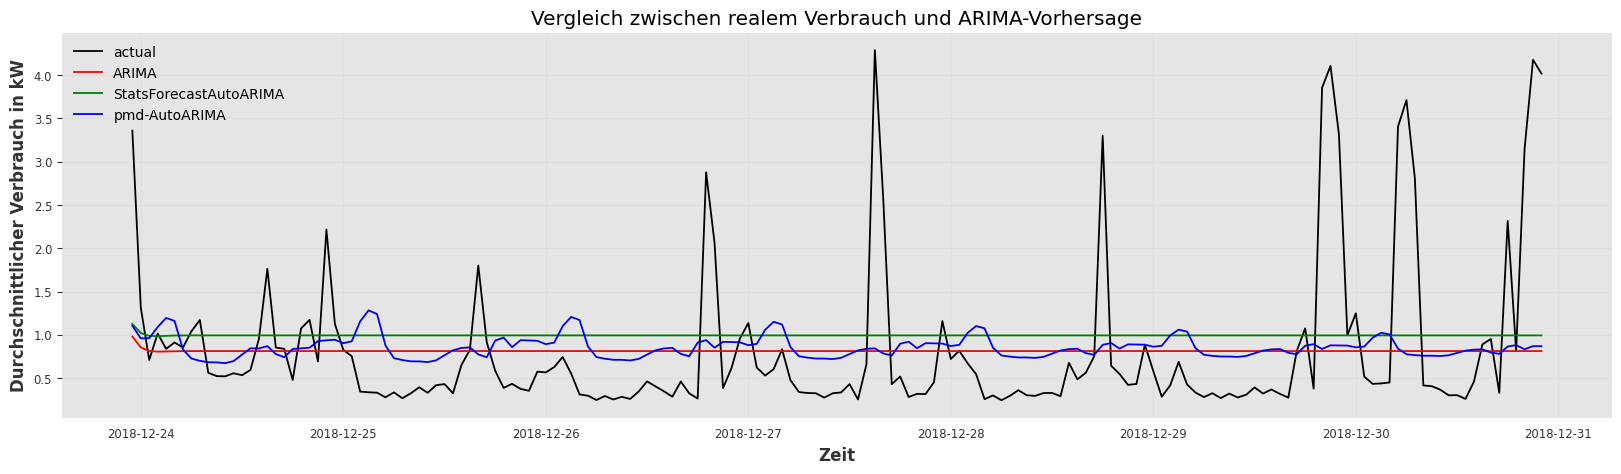

In [16]:
datapoints_week = 24 * 7
last_start_idx = len(df_comp) - datapoints_week - 1
start_idx = random.randint(0, last_start_idx)
end_idx = start_idx + datapoints_week
df_plot = df_comp[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.actual, color='black', label='actual')
plt.plot(df_plot.index, df_plot.predicted, color='red', label='ARIMA')
plt.plot(df_plot.index, df_plot.predicted_faster_auto, color='green', label='StatsForecastAutoARIMA')
plt.plot(df_plot.index, df_plot.predicted_auto, color='blue', label='pmd-AutoARIMA')
plt.title('Vergleich zwischen realem Verbrauch und ARIMA-Vorhersage')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch in kW')
plt.legend()
plt.show()

In [23]:
# Als csv-Datei speichern
df_save = pd.DataFrame(df_comp['predicted_auto'])
df_save.reset_index(inplace=True)
df_save.columns = ['timestamp', 'predicted_arima']
df_save.to_csv('arima_1642.csv', index=False)

## Probleme und To-do
* Dickey-Fuller-Test & Saisonalität
* Warum verändert sich Stromverbrauch in der Nacht, im Sommer, am Wochenende etc.
* Konstante Vorhersage
* Unterschied predict() und forecast()
* Overfitting mit predict() auf ARIMA?
* https://www.kaggle.com/learn/time-series